In [1]:
## TODO : semantic chunking한 결과 나타내는데 좀 더 잘 할 수 있는 방법 없는지 생각하기
## log 개선하기(일단 기능 완성해서 붙이고 해도 됨.)
## threshod 방식 말고 다른거 있는지 생각하기 (x) -> option 추가함
## 이거 평균내서 best summary 이용하면 될 듯, 그리고 context가 빈 칸인 경우 제외하게 해야 함.

import pickle
import os

## filename handle

file_name = "example/sample_file.pdf"
file_name_seperated = os.path.splitext(os.path.basename(file_name))[0]
### result table summary cache handle
context_result_file_path = f"pkl/{file_name_seperated}_context.pkl"
langchain_result_file_path = f"pkl/{file_name_seperated}_langchain_summary_results.pkl"
dspy_result_file_path = f"pkl/{file_name_seperated}_dspy_summary_results.pkl"
groq_result_file_path = f"pkl/{file_name_seperated}_groq_summary_results.pkl"

In [2]:
# origin = f"pkl/{file_name_seperated}.pkl"

# with open(origin, "rb") as f:
#     origin_elements = pickle.load(f)

# print(origin_elements.elements)

In [3]:
# Summarize한 context 가져오기
with open(context_result_file_path, 'rb') as f:
    full_context = pickle.load(f)

# Langchain 결과 불러오기
with open(langchain_result_file_path, 'rb') as f:
    langchain_results = pickle.load(f)

# DSPy 결과 불러오기
with open(dspy_result_file_path, 'rb') as f:
    dspy_results = pickle.load(f)

# GROQ 결과 불러오기
with open(groq_result_file_path, 'rb') as f:
    groq_results = pickle.load(f)

print("Full context related:", full_context)
print("Langchain Results:", langchain_results)
print("DSPy Results:", dspy_results)
print("GROQ Results:", groq_results)

FileNotFoundError: [Errno 2] No such file or directory: 'pkl/sample_file_groq_summary_results.pkl'

In [ ]:
print(full_context[0])

The chemical composition of the steel shall be determined by the ladle analysis and the value shall be as given in Table 1.

Element Composition % Carbon Silicon Manganese Phosphorus Sulfur Chromium Copper Oxygen Nickel Molybdenum Chromium & Nickel Vanadium DI (Ideal Diameter) 1.4 - 1.80 (Calculated) ASTM A 255 0.42 - 0.48 0.15 - 0.35 0.60 - 0.90 0.030 Max 0.035 Max 0.10 - 0.20 0.30 Max less than 20PPM 0.20 Max 0.04 Max Not to exceed 0.35% 0.100 Max



In [17]:
from rouge_score import rouge_scorer

def evaluate_summary(original, summary):
    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(original, summary)

    return {
        "ROUGE-1": rouge_scores['rouge1'].fmeasure,
        "ROUGE-2": rouge_scores['rouge2'].fmeasure,
        "ROUGE-L": rouge_scores['rougeL'].fmeasure,
    }

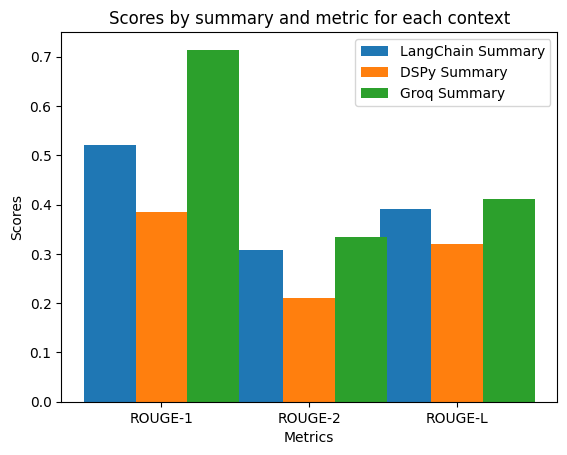

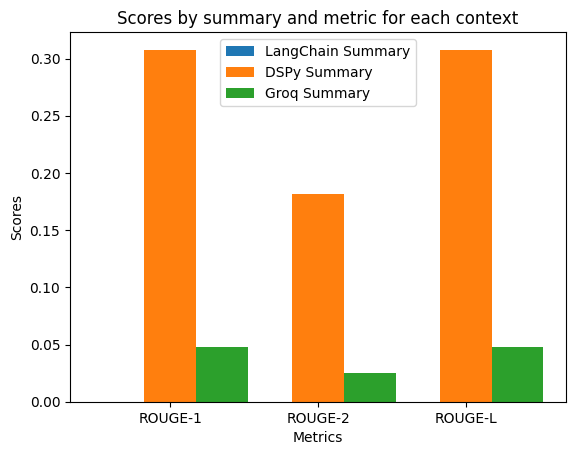

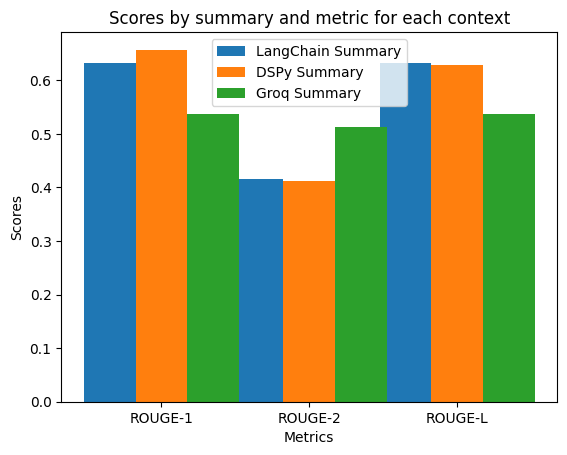

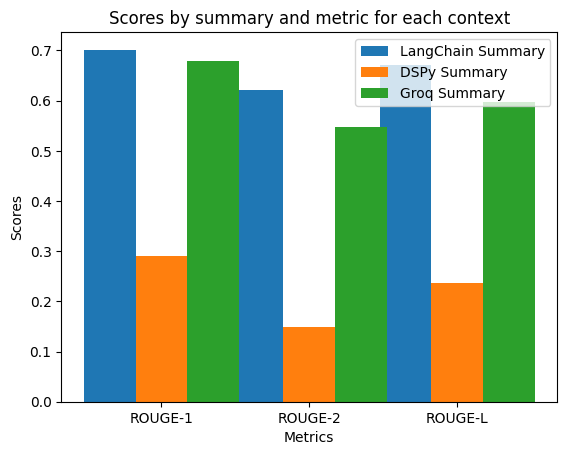

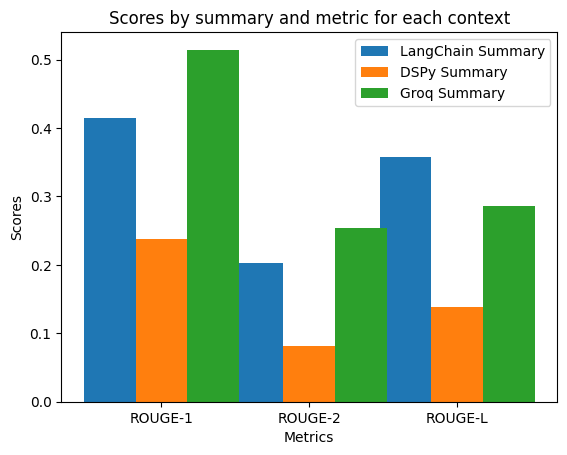

Context 1 - Overall Score for LangChain Summary: 0.4032
Context 1 - Overall Score for DSPy Summary: 0.3021
Context 1 - Overall Score for Groq Summary: 0.4813
Best Summary for Context 1: Groq Summary
Context 2 - Overall Score for LangChain Summary: 0.0000
Context 2 - Overall Score for DSPy Summary: 0.2631
Context 2 - Overall Score for Groq Summary: 0.0400
Best Summary for Context 2: DSPy Summary
Context 3 - Overall Score for LangChain Summary: 0.5551
Context 3 - Overall Score for DSPy Summary: 0.5602
Context 3 - Overall Score for Groq Summary: 0.5232
Best Summary for Context 3: DSPy Summary
Context 4 - Overall Score for LangChain Summary: 0.6581
Context 4 - Overall Score for DSPy Summary: 0.2229
Context 4 - Overall Score for Groq Summary: 0.6014
Best Summary for Context 4: LangChain Summary
Context 5 - Overall Score for LangChain Summary: 0.3215
Context 5 - Overall Score for DSPy Summary: 0.1508
Context 5 - Overall Score for Groq Summary: 0.3479
Best Summary for Context 5: Groq Summary


In [18]:
import matplotlib.pyplot as plt

overall_scores = []
weights = {'ROUGE-1': 0.33, 'ROUGE-2': 0.33, 'ROUGE-L': 0.33}

for doc, langchain, dspy, groq in zip(full_context, langchain_results, dspy_results, groq_results):
    results_langchain = evaluate_summary(doc, langchain)
    results_dspy = evaluate_summary(doc, dspy)
    results_groq = evaluate_summary(doc, groq)

    # 가중치를 적용한 종합 점수 계산
    score_langchain = sum(results_langchain[key] * weights[key] for key in results_langchain)
    score_dspy = sum(results_dspy[key] * weights[key] for key in results_dspy)
    score_groq = sum(results_groq[key] * weights[key] for key in results_groq)

    overall_scores.append((score_langchain, score_dspy, score_groq))

    metrics = results_langchain.keys()
    scores_langchain = [results_langchain[m] for m in metrics]
    scores_dspy = [results_dspy[m] for m in metrics]
    scores_groq = [results_groq[m] for m in metrics]

    fig, ax = plt.subplots()
    index = range(len(metrics))
    bar_width = 0.25  # 바 너비를 줄입니다.
    spacing = 0.1     # 바 간격을 추가합니다.

    rects1 = ax.bar([p - bar_width - spacing for p in index], scores_langchain, bar_width, label='LangChain Summary')
    rects2 = ax.bar(index, scores_dspy, bar_width, label='DSPy Summary')
    rects3 = ax.bar([p + bar_width + spacing for p in index], scores_groq, bar_width, label='Groq Summary')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Scores by summary and metric for each context')
    ax.set_xticks(index)  # X축 눈금 위치를 조정합니다.
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()

for idx, (score_langchain, score_dspy, score_groq) in enumerate(overall_scores, start=1):
    print(f"Context {idx} - Overall Score for LangChain Summary: {score_langchain:.4f}")
    print(f"Context {idx} - Overall Score for DSPy Summary: {score_dspy:.4f}")
    print(f"Context {idx} - Overall Score for Groq Summary: {score_groq:.4f}")
    best_summary = 'LangChain Summary' if score_langchain > score_dspy else 'DSPy Summary'
    best_summary = 'Groq Summary' if score_groq > max(score_langchain, score_dspy) else best_summary
    print(f"Best Summary for Context {idx}: {best_summary}")

In [20]:
import phoenix as px
session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📺 To view the Phoenix app in a notebook, run `px.active_session().view()`
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [21]:
# import phoenix.experimental.evals.templates.default_templates as templates
# from phoenix.experimental.evals import (
#     OpenAIModel,
#     download_benchmark_dataset,
#     llm_classify,
# )

# model = OpenAIModel(
#     model_name="gpt-3.5-turbo",
#     temperature=0.0,
# )

# #The rails is used to hold the output to specific values based on the template
# #It will remove text such as ",,," or "..."
# #Will ensure the binary value expected from the template is returned 
# rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())

# summarization_classifications = llm_classify(
#     dataframe=df_sample,
#     template=templates.SUMMARIZATION_PROMPT_TEMPLATE,
#     model=model,
#     rails=rails,
#     provide_explanation=True, #optional to generate explanations for the value produced by the eval LLM
# )

In [22]:
import pandas as pd
df_langchain = pd.DataFrame({
    "input": full_context,  # context 데이터를 input 열로 설정
    "output": langchain_results  # langchain 결과를 output 열로 설정
})

# DataFrame 생성: context와 dspy 결합
df_dspy = pd.DataFrame({
    "input": full_context,  # context 데이터를 input 열로 설정
    "output": dspy_results  # dspy 결과를 output 열로 설정
})

In [23]:
import os
from getpass import getpass
import phoenix.evals.default_templates as templates
import matplotlib.pyplot as plt
import openai
import pandas as pd


from phoenix.evals import (
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

model = OpenAIModel(
    model="gpt-3.5-turbo",
    temperature=0.0,
)

In [24]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned

rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_classify(
    dataframe=df_dspy,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

In [25]:
print(summarization_classifications)

['good', 'good', 'bad', 'good', 'good']


In [26]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(templates.SUMMARIZATION_PROMPT_RAILS_MAP.values())
summarization_classifications = llm_classify(
    dataframe=df_langchain,
    template=templates.SUMMARIZATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

In [27]:
print(summarization_classifications)

['good', 'bad', 'good', 'good', 'bad']
